In [1]:
# Imports
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
device = torch.device('cuda')

from layer_importance.evaluate import test_network
from layer_importance.prune import prune_network

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

In [ ]:
# Train baseline VGG16 model for 50 epochs on CIFAR-10 dataset

In [3]:
!python -Wi -m layer_importance.main \
--train-flag \
--epoch 20 \
--data-set CIFAR10 \
--vgg vgg16_bn \
--save-path ./trained_models/

-*--*--*--*--*--*--*--*--*--*-
	Arguments
-*--*--*--*--*--*--*--*--*--*-
gpu_no: 0
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 20
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None
Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*- Train network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 01:03:17 2022: Epoch [0], Iteration [0/391/], Data(s): 0.077, Loss(s): 0.008, Forward(s): 0.421, Backward(s): 0.317, Top1: 12.500, Top5: 43.7500, Loss: 2.487
Fri Dec 16 01:03:22 2022: Epoch [0], Iteration [100/391/], Data(s): 0.038, Loss(s): 0.002, Forward(s): 0.008, Backward(s): 0.010, Top1: 14.434, Top5: 60.02

In [4]:
print(f"Original Model Size = {os.path.getsize('trained_models/check_point.pth') / (1024 * 1024) :.1f} MB")

Original Model Size = 57.3 MB


In [5]:
# View created args 
load_path = 'trained_models/'
args = torch.load(load_path+'arguments.pth')

for key, value in vars(args).items():
    print("%s: %s"%(key, value))

#################################
args.load_path = load_path + 'check_point.pth'
args.save_path = load_path+'%s/'%time.ctime().replace(' ', '_')
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

gpu_no: 0
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 20
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None


In [6]:
# Evaluate baseline model on test data
network, test_set, (top1, top5) = test_network(args)

Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 01:11:06 2022: Test information, Data(s): 1.784, Forward(s): 0.357, Top1: 79.350, Top5: 98.150, 


In [7]:
print(f"Original Model Size = {os.path.getsize('trained_models/check_point.pth') / (1024 * 1024) :.1f} MB")
params = sum([np.prod(p.size()) for p in network.parameters()])
print("Original Number of Parameters: %.1fM"%(params/1e6))

Original Model Size = 57.3 MB
Original Number of Parameters: 15.0M


In [8]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

In [ ]:
# Analyze layers based on absolute magnitude of filter weights

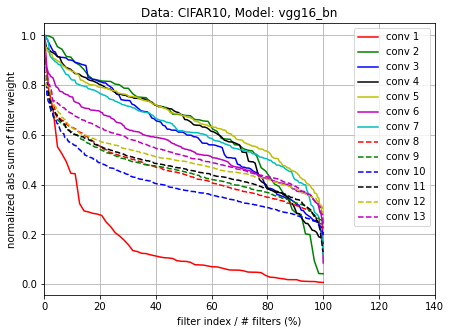

In [9]:
plt.figure(figsize=(7,5))
conv_count = 0
fw_list = []

for layer in network.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count%len(colors)] + lines[conv_count//len(colors)]
        
        # filter weight dimension info: out_ch, in_ch, k1, k2
        fw = layer.weight.data.cpu().numpy()
        fw_list.append(fw)
        
        # sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # normalize with maximum value
        normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label='conv %d'%conv_count)
        
plt.title("Data: %s, Model: %s"%(args.data_set, args.vgg))        
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("figure1.png", dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Evaluate normalized sum of layer weights
for i, fw in enumerate(fw_list):
    # print(f'Conv{i+1} total sum = {np.sum(np.abs(fw.reshape(fw.shape[0], -1))):.3f}')
    sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
    normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
    print(f'Conv{i+1} Normalized sum = {np.sum(normalized_abs_sum):.3f}')
    print()

Conv1 Normalized sum = 10.690

Conv2 Normalized sum = 40.653

Conv3 Normalized sum = 77.813

Conv4 Normalized sum = 79.908

Conv5 Normalized sum = 169.666

Conv6 Normalized sum = 142.414

Conv7 Normalized sum = 160.150

Conv8 Normalized sum = 234.302

Conv9 Normalized sum = 235.557

Conv10 Normalized sum = 207.233

Conv11 Normalized sum = 241.669

Conv12 Normalized sum = 257.756

Conv13 Normalized sum = 271.435



In [11]:
# Check model structure before pruning
print('--- Before Pruning ---')
print(network)

--- Before Pruning ---
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [12]:
# Define sequential model pruning approach: Prune 10% of filters of each layer iteratively upto max 90%
prune_step_ratio = 1/8
max_channel_ratio = 0.90 

prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 
                'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']

In [14]:
# Prune model iteratively without finetuning and check layer importance

top1_accuracies = {}
top5_accuracies = {}
model_size = defaultdict(list)
model_params = defaultdict(list)

# Consider each conv layer one by one
for conv, channel in zip(prune_layers, prune_channels):
    print(f'============== Working with layer {conv} ==============')
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    # Prune 10% of filters in each step
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information and prune network
        args.prune_layers = [conv]
        args.prune_channels = [steps[i]]
        network = prune_network(args, network)
        
        # evaluate network on test data after pruning
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)
        
    # Save evaluation metrics
    print('============================')
    size = os.path.getsize('trained_models/check_point_pruned.pth') / (1024 * 1024)
    print(f"Model Size = {size:.1f} MB")
    model_size[conv].append(size)

    params = sum([np.prod(p.size()) for p in network.parameters()])/1e6
    model_params[conv].append(params)
    print("Number of Parameters: %.1fM"%(params))
    print('============================')


============== Working with layer conv1 ==============
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 01:11:11 2022: Test information, Data(s): 1.651, Forward(s): 0.248, Top1: 79.350, Top5: 98.150, 

Fri Dec 16 01:11:11 2022: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*- Prune network -*--*--*--*--*--*--*--*--*--*-
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 01:11:13 2022: Test information, Data(s): 1.661, Forward(s): 0.248, Top1: 79.340, Top5: 98.140, 

Fri Dec 16 01:11:14 2022: conv1 Layer, 16 Channels pruned
-*--*--*--*--*--*--*--*--*--*- Prune network -*--*--*--*--*--*--*--*--*--*-
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 01:11:16 2022: Test information, Data(s): 1.616, Forward(s): 0.242, Top1: 79.270, Top5: 98.130, 

Fri Dec 16 01:11:16 2022: conv1 Layer, 24 Channels pruned
-*--*--*--*--*--*--*--*--*--*- Prune network -*--*--*--*

In [16]:
model_params

defaultdict(list,
            {'conv1': [14.957404],
             'conv2': [14.893279],
             'conv3': [14.792881],
             'conv4': [14.594161],
             'conv5': [14.196376],
             'conv6': [13.931416],
             'conv7': [13.401496],
             'conv8': [11.811046],
             'conv9': [10.751206],
             'conv10': [10.751206],
             'conv11': [10.751206],
             'conv12': [10.751206],
             'conv13': [12.635366]})

In [ ]:
# Check layer importance based on iterative pruning without finetuning

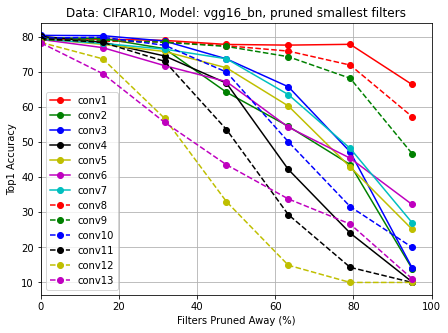

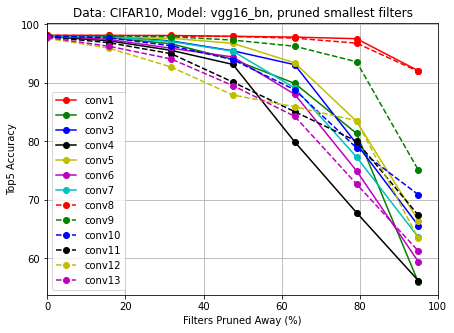

In [17]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top5.png", dpi=150, bbox_inches='tight')
plt.show()                


In [ ]:
# Repeat above process but also do finetuning (retraining with small LR) after pruning at each step

In [18]:
args.retrain_flag = True
args.retrain_epoch = 3
args.independent_prune_flag = False
args.retrain_lr = 0.001

In [19]:
# Prune model iteratively with finetuning and check layer importance

top1_accuracies = {}
top5_accuracies = {}
model_size = defaultdict(list)
model_params = defaultdict(list)

# Consider each conv layer one by one
for conv, channel in zip(prune_layers, prune_channels):
    print(f'============== Working with layer {conv} ==============')
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    # Prune 10% of filters in each step
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information and prune network
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]
        network = prune_network(args, network)
        
        # evaluate network on test data after pruning        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

    # Save evaluation metrics
    print('============================ ')
    size = os.path.getsize('trained_models/check_point_pruned.pth') / (1024 * 1024)
    print(f"Model Size = {size:.1f} MB")
    model_size[conv].append(size)

    params = sum([np.prod(p.size()) for p in network.parameters()])/1e6
    model_params[conv].append(params)
    print("Number of Parameters: %.1fM"%(params))
    print('============================ ')


============== Working with layer conv1 ==============
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 01:43:41 2022: Test information, Data(s): 1.701, Forward(s): 0.247, Top1: 79.350, Top5: 98.150, 

Fri Dec 16 01:43:41 2022: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*- Prune network -*--*--*--*--*--*--*--*--*--*-
Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*- Train network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 01:43:43 2022: Epoch [0], Iteration [0/391/], Data(s): 0.042, Loss(s): 0.000, Forward(s): 0.135, Backward(s): 0.221, Top1: 81.250, Top5: 97.6562, Loss: 0.564
Fri Dec 16 01:43:48 2022: Epoch [0], Iteration [100/391/], Data(s): 0.035, Loss(s): 0.002, Forward(s): 0.005, Backward(s): 0.008, Top1: 86.665, Top5: 99.2265, Loss: 0.414
Fri Dec 16 01:43:53 2022: Epoch [0], Iteration [200/391/], Data(s): 0.035, Loss(s): 0.002, Forward(s): 0.004, Backward(s): 0.007, Top1: 87.407, Top5: 99.2421, Loss: 0.368

In [ ]:
# Check layer importance based on iterative pruning with finetuning

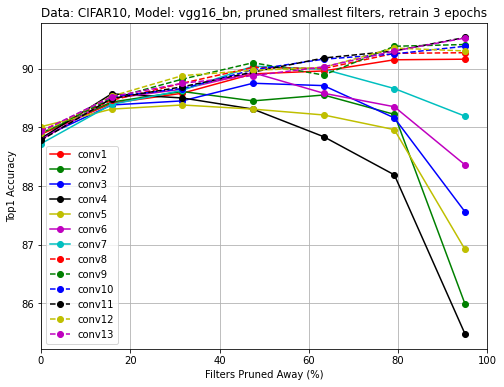

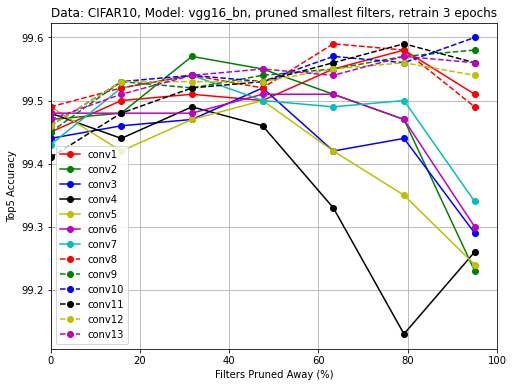

In [34]:
plt.figure(figsize=(8,6))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure3_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(8,6))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure3_top5.png", dpi=150, bbox_inches='tight')
plt.show()                


In [22]:
model_params

defaultdict(list,
            {'conv1': [14.957404],
             'conv2': [14.893279],
             'conv3': [14.792881],
             'conv4': [14.594161],
             'conv5': [14.196376],
             'conv6': [13.931416],
             'conv7': [13.401496],
             'conv8': [11.811046],
             'conv9': [10.751206],
             'conv10': [10.751206],
             'conv11': [10.751206],
             'conv12': [10.751206],
             'conv13': [12.635366]})

In [31]:
 model_params.values()

dict_values([[14.957404], [14.893279], [14.792881], [14.594161], [14.196376], [13.931416], [13.401496], [11.811046], [10.751206], [10.751206], [10.751206], [10.751206], [12.635366]])

In [ ]:
# Plot progression of MACs with iterative pruning rounds

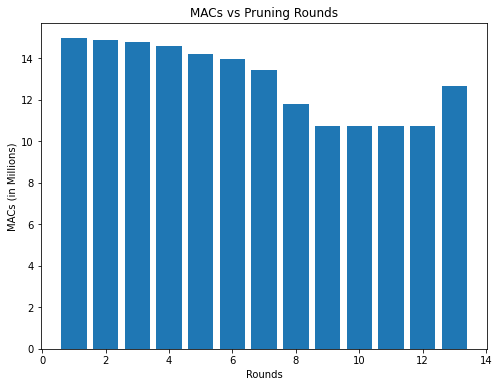

In [32]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 14), [a[0] for a in list(model_params.values())])
plt.xlabel('Rounds')
plt.ylabel('MACs (in Millions)')
plt.title('MACs vs Pruning Rounds')
plt.show()